# Visualize and Analyze Data

This notebook will explore the data we downloaded in the `Customize and Access Data` notebook by performing the following steps:

1. Read in ATL07 data
2. Convert to delta time
3. Compute along track distance per beam
4. Read in MOD29 data 
5. Apply scale

and plot against MODIS Corrected Reflectance (true color) imagery
2. Overlay ATL07 data over MODIS IST
3. Extract MODIS IST values along ICESat-2 heights
4. Extract ICESat-2 heights along MODIS IST values.
5. Plot MODIS IST and ICESat-2 heights
   

### Import packages

In [ ]:
# Need to install `plotly` on top of Pangeo
!conda install -c plotly plotly=4.3.0 -y

# Need to instal `awscli` on top of Pangeo 
!conda install awscli -y
!conda list | grep pyproj

# Need to upgrade `pyproj` on this Pangeo environment. Had some issues getting this to install in our environment but this worked:
import sys
!{sys.executable} -m pip install pyproj==2.4.1

In [1]:
%run functions.py

In [9]:
from collections import defaultdict
from osgeo import gdal, osr
import math
import h5py
import xarray as xr
import pyproj
import pandas as pd
from shapely.geometry import Point,Polygon
import pyresample as prs
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import hvplot.pandas  # Adds the 'hvplot' method to pandas objects
import hvplot.xarray  # Adds the 'hvplot' method to xarray objects
import rasterio
import functions
import numpy as np
from holoviews.operation.datashader import datashade
import datashader.geo

%matplotlib inline

In [41]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_0135_006_2019082132035_HEGOUT.hdf to Outputs/MOD29_A2019082_0135_006_2019082132035_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_0000_006_2019082132032_HEGOUT.hdf to Outputs/MOD29_A2019082_0000_006_2019082132032_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_1300_006_2019083012923_HEGOUT.hdf to Outputs/MOD29_A2019082_1300_006_2019083012923_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_1305_006_2019083013016_HEGOUT.hdf to Outputs/MOD29_A2019082_1305_006_2019083013016_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_0320_006_2019082132046_HEGOUT.hdf to Outputs/MOD29_A2019082_0320_006_2019082132046_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_0950_006_2019082191702_HEGOUT.hdf to Outputs/MOD29_A2019082_0950_006_2019082191702_HEGOUT.hdf
download: s3://nsidc-agu-tutorial-data/MOD29_A2019082_0315_006_2019082132027_HEGOUT.hdf to Outputs/MOD29_A201908

## Read in ATL07 and perform calculations

We will be using a few different packages to bring our data in...

* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html)
    * Pandas is built on top of NumPy and provides easy to work with data structures. The pandas dataframe is a 2-D tabular data structure with labeled axes. 
* [GeoPandas GeoDataFrame](http://geopandas.org/reference/geopandas.GeoDataFrame.html) 
    * A GeoDataFrame object is a pandas.DataFrame that has a column with geospatial capabilities.
* [Gdal](https://pypi.org/project/GDAL/)
    * Tools for programming and manipulating the Geospatial Data Abstraction Library (GDAL).
* [Rasterio](https://rasterio.readthedocs.io/en/stable/index.html)
    * Rasterio reads and writes raster formats including GeoTIFF.
* [Xarray](http://xarray.pydata.org/en/stable/index.html)
    * Designed for multidimensional data. Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays. 

### Load ATL07 granules into dataframes

We will start by defining variables to extract and combine as a single dataframe:

In [3]:
VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg'
    ]
}

#### We will use the `load_icesat2_as_dataframe` function from our functions module to load points from our ATL07 files: 

In [4]:
# Load ATL07 granules and combine into single ATL07 dataframe

atl07_1298 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
atl07_1305 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)

atl07 = pd.concat([atl07_1298,atl07_1305]) #concatenate dataframes to use in plot below

atl07_1298

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
0,gt3l,3.857279e+07,0.010683,0.676916,10.098009,1,0.025361,79.999983,151.881138,processed_ATL07-01_20190323101341_12980201_002...
1,gt3l,3.857279e+07,0.012471,0.619781,11.594363,1,0.022021,79.999935,151.881056,processed_ATL07-01_20190323101341_12980201_002...
2,gt3l,3.857279e+07,0.012472,0.507711,10.911974,1,0.019280,79.999888,151.880978,processed_ATL07-01_20190323101341_12980201_002...
3,gt3l,3.857279e+07,0.008859,0.329125,11.597196,1,0.019696,79.999842,151.880901,processed_ATL07-01_20190323101341_12980201_002...
4,gt3l,3.857279e+07,0.014333,0.200405,11.587672,1,0.020255,79.999791,151.880816,processed_ATL07-01_20190323101341_12980201_002...
...,...,...,...,...,...,...,...,...,...,...
361623,gt2l,3.857291e+07,0.009685,0.133931,15.602032,1,0.018704,72.667179,144.384416,processed_ATL07-01_20190323101341_12980201_002...
361624,gt2l,3.857291e+07,0.007970,0.107124,15.435792,1,0.018630,72.667113,144.384377,processed_ATL07-01_20190323101341_12980201_002...
361625,gt2l,3.857291e+07,0.012603,0.102050,13.881675,1,0.022842,72.667053,144.384340,processed_ATL07-01_20190323101341_12980201_002...
361626,gt2l,3.857291e+07,0.009838,0.125114,13.948715,1,0.023344,72.667000,144.384309,processed_ATL07-01_20190323101341_12980201_002...


### Convert ATL07 'delta_time' to utc datetime values

In [5]:
# Add datetime values to each dataframe

for df in [atl07_1298, atl07_1305]:
    df['utc_datetime'] = df['delta_time'].apply(functions.convert_delta_time)
    df = df.drop(columns = 'delta_time')

atl07_1305

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,utc_datetime
0,gt3l,3.861196e+07,NaN,NaN,7239.744629,0,NaN,72.232936,149.395920,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.107868
1,gt3l,3.861196e+07,NaN,NaN,3620.920410,0,NaN,72.232936,149.395920,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.107868
2,gt3l,3.861196e+07,NaN,NaN,1811.385376,0,NaN,72.232936,149.395920,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.107868
3,gt3l,3.861196e+07,NaN,NaN,908.146240,0,NaN,72.232936,149.395920,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.107868
4,gt3l,3.861196e+07,NaN,NaN,455.501556,0,NaN,72.232936,149.395920,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:32:36.107868
...,...,...,...,...,...,...,...,...,...,...,...
222253,gt2l,3.861208e+07,0.012982,0.113614,68.521347,0,0.015252,79.998620,143.628558,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:34:40.028468
222254,gt2l,3.861208e+07,0.015750,0.134127,72.568794,0,0.013815,79.998943,143.628147,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:34:40.033644
222255,gt2l,3.861208e+07,0.018621,0.108765,69.399681,0,0.013030,79.999268,143.627737,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:34:40.038875
222256,gt2l,3.861208e+07,0.017971,0.147414,65.762260,0,0.014212,79.999569,143.627361,processed_ATL07-01_20190323211343_13050201_002...,2019-03-23 21:34:40.043741


### Compute along track distance

The `height_segment_length_seg` variable provides the length of each segment. We need these values to be additive so that we can plot against distance.  

# **Luis** Please code review the compute_distance function. It's pretty clunky. I also couldn't do a simple loop over both dataframes like I did with the time function above (see commented below). 

In [6]:
atl07_1298 = functions.compute_distance(atl07_1298)
atl07_1305 = functions.compute_distance(atl07_1305)


# #THIS WONT APPLY THE FUNCTION
# for df in [atl07_1298, atl07_1305]:
#     df = functions.compute_distance(df)

## Read in MODIS Ice Surface Temperature file and perform calculations

There were 13 granules returned over our time and area of interest. We can use Earthdata Search to easily visualize the coverage of each granule:
[MODIS Earthdata Search link](https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!)

Let's choose a single MODIS granule to be used in our analysis below. 

Out of the 13 returned, these all have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And after viewing the browse images, this looks to have the best data coverage:

* MOD29.A2019082.0140.006.2019082132036.hdf


### Load the MOD29 file into xarray

In [14]:
# Define local filepath and open as xarray

filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf'

mod29 = xr.open_dataset(filepath)
mod29

<xarray.Dataset>
Dimensions:                           (Along_swath_lines_1km:MOD_Swath_Sea_Ice: 932, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice: 932, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice: 389, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice: 389)
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_Sea_Ice, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice
Data variables:
    Latitude                          (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Longitude                         (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance            (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance_Pixel_QA   (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Ice_Surface_Temperature           (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Ice_Surface_Temperature_Pixel_QA  (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
Attributes:
    HDFEOSVersion:     HDFEOS_V2.20
    StructMetadata.0:  GROUP=SwathStructure\n\tGROUP=SWATH_1\n\t\tSwathName="...

### Convert calibrated data to Kelvin

Before we plot the ATL07 heights over MODIS IST, we need to convert the Ice_Surface_Temperature values to kelvin. According to the [MOD29 User Guide](https://nsidc.org/data/mod29#title11) the Ice_Surface_Temperature (IST) values are stored as calibrated data. To convert to kelvin, use scale_factor = 0.01 and add_offset = 0.0 in the following equation:

IST = scale_factor × (calibrated data - add_offset)

The valid range for ISTs is 210 K to 313.20 K.

Let's apply this conversion to our xarray:

In [16]:
mod29['Ice_Surface_Temperature'] = mod29['Ice_Surface_Temperature']*(0.01) # Apply calibrated data to kelvin conversion

### Load MODIS IST image

A GeoTIFF was created using the NASA Worldview snapshot feature from MO29 high-resolution browse imagery: </n> 

MODIS IST: https://go.nasa.gov/34fBnp8

We'll read in the projection information below to help inform our plotting projection parameters in the next step:

In [43]:
# Read geotiff images from gdal 
gdal.UseExceptions()

fname_ist = './Outputs/snapshot-2019-03-23T00_00_00Z-IST.tiff'

ds_ist = gdal.Open(fname_ist)
proj_ist = ds_ist.GetProjection()
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj_ist)

#Print proj4 string
proj4_ist = inproj.ExportToProj4()
print('MODIS IST proj4:',proj4_cr)

MODIS IST proj4: +proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 


## Visualize ICESat-2 height values over MODIS Ice Surface Temperature

We can visualize the ICESat-2 track locations and height values overlayed with MODIS Ice Surface Temperature. We should see higher ATL07 heights along fast ice, with lower heights over thin ice and then increasing height over drift ice.  [YOU WILL GET A MESSAGE IF YOU FIRST DOWNLOADED THE COASTLINE] [add ist values and crop image] [CHANGE WIDTH / HEIGHTS]

In [55]:
# Read in data using rasterio
#source_ist = xr.open_rasterio(fname_ist)
source_ist = rasterio.open(fname_ist, 'r')
bounds_ist = (source_ist.bounds.left, source_ist.bounds.right, \
          source_ist.bounds.bottom, source_ist.bounds.top)


# Luis: Can you add the color scale for the MODIS image?

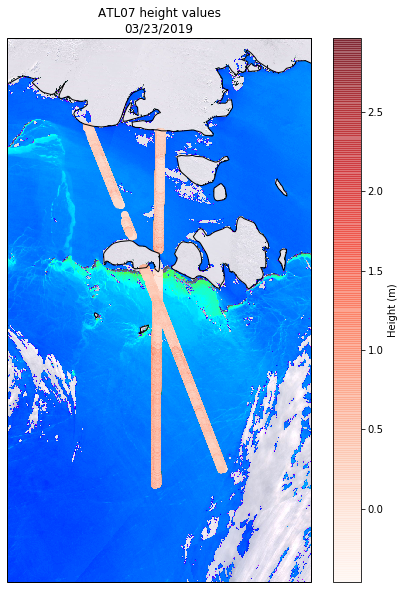

In [65]:
# Plot ICESat-2 over MODIS IST

fig = plt.figure(figsize=(8, 10))
img = plt.imread(fname_ist)
plot_proj = ccrs.Stereographic(central_longitude=-45, central_latitude=90, 
                               false_easting=0, false_northing=0,
                               true_scale_latitude=70)

ax = plt.axes(projection=plot_proj)
plt.title('ATL07 height values\n'
          '03/23/2019')

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tiff, the "origin" of the image is in the upper left corner
ax.imshow(img, origin='upper', extent=bounds_ist, transform=plot_proj)
ax.coastlines(resolution='50m', color='black', linewidth=1)

heights = ax.scatter(atl07.longitude, atl07.latitude, transform=ccrs.Geodetic(),
          c=atl07.height_segment_height,
          cmap='Reds', alpha=0.6)              

cbar = fig.colorbar(heights, ax=ax)
cbar.set_label('Height (m)')
plt.show()

#### How does this look in 3d?

Coming soon...

... maybe not necessary...


In [ ]:
# From OpenAltimetry notebook:

# # Paste the OpenAltimetry selection parameters here
# OA_REFERENCE_URL = 'minx=72.0476&miny=36.6165&maxx=72.0505&maxy=36.6214&date=2019-05-02&trackId=516'
# # We populate a list with the photon data using the OpenAltimetry API, no HDF! 
# OA_URL = 'https://openaltimetry.org/data/icesat2/getPhotonData?client=jupyter&' + OA_REFERENCE_URL

# OA_PHOTONS = ['Noise', 'Low', 'Medium', 'High']
# # OA_PLOTTED_BEAMS = [1,2,3,4,5,6] you can select up to 6 beams for each ground track.
# # Some beams may not be usable due cloud covering or QC issues.
# OA_BEAMS = [3,4]

# df_beams = []
# oa_plots = []

# # This function will request the 6 tracks using OpenAltimetry's API
# def getPhotonData():
#     series = []
#     beam_index = 0;
#     for beam in OA_BEAMS:
#         beam_index += 1
#         b_url = OA_URL + '&beam=' + str(beam)
#         print(b_url)
#         print('Requesting Beam {}'.format(beam_index))
#         r = requests.get(b_url)
#         data = r.json()
#         series.append(data)
#     print ('Data requests completed you can now plot it on the next cell...')
#     return series

        
# photon_cloud = getPhotonData()

# track_index = 0
# for track in photon_cloud:
#     track_index +=1
#     for photons in track['series']:
#         if any(word in photons['name'] for word in OA_PHOTONS):
#             series = []
#             for p in photons['data']:
#                 series.append({
#                     'lat': p[0],
#                     'lon': p[2],
#                     'h': p[1]
#                 })
#             if (len(series) > 0):
#                 df = pd.DataFrame.from_dict(series)
#                 df.name = 'Beam ' + str(track_index) + ' ' + photons['name']
#                 df_beams.append(df) 

# for df in df_beams:
#     oa_plots.append(go.Scatter3d(name=df.name, x=df['lat'], y=df['lon'], z=df['h'], mode='markers',
#                                     marker=dict(
#                                         size=1,
#                                         color=df['h'],
#                                         colorscale='Viridis',   # choose a colorscale
#                                         opacity=0.8
#                                     )
#                                 )
#                    )
    
    
# layout = go.Layout(
#     width=900,
#     height=600,
#     scene = dict(aspectmode = 'manual', aspectratio =dict(x=1, y=1, z=0.5),
#                  xaxis=dict(title='Latitude'), yaxis=dict(title='Longitude'), zaxis=dict(title='Elevation (m)'))
# )

# fig = go.Figure(data=oa_plots, layout=layout)  

# iplot(fig)


# # Now we can get a histogram of the beam's elevation and their description
# for df in df_beams:
#     print(df.describe())
#     df.hist('h', bins=128)
    

In [34]:
# title = 'MOD29 Ice Surface Temperature (K)'
rasterized_ist = mod29.Ice_Surface_Temperature.hvplot.image(rasterize=True, 
                                         cmap='viridis', height=400, width=800).redim.range(Ice_Surface_Temperature=(240,270))
rasterized_ist.options(cmap='viridis')


#Incorporate ICESat-2 values
# datashade(df_atl07.hvplot.points(x='longitude', y='latitude'))
# x, y = datashader.geo.lnglat_to_meters(df_atl07.longitude, df_atl07.latitude)

# mod29.Ice_Surface_Temperature.hvplot.quadmesh('Along_swath_lines_1km:MOD_Swath_Sea_Ice', 'Cross_swath_pixels_1km:MOD_Swath_Sea_Ice', projection=test, project=True, 
#                                               cmap='viridis', rasterize=True, dynamic=False,).redim.range(Ice_Surface_Temperature=(240,700))

:DynamicMap   []
   :Image   [Cross_swath_pixels_1km:MOD_Swath_Sea_Ice,Along_swath_lines_1km:MOD_Swath_Sea_Ice]   (Ice_Surface_Temperature)

## Extract MODIS IST values along the ICESat-2 tracks

Now that we've visually inspected height and IST values, let's do some analysis. We will now extract MODIS IST values at each ATL07 point.


### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [ ]:
icesat2_geometry_101341 = prs.geometry.SwathDefinition(lons=df_07_101341['longitude'], lats=df_07_101341['latitude'])
icesat2_geometry_211343 = prs.geometry.SwathDefinition(lons=df_07_211343['longitude'], lats=df_07_211343['latitude'])

mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])
df_07_101341['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_101341, radius_of_influence=1000, fill_value=np.nan)
df_07_211343['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_211343, radius_of_influence=1000, fill_value=np.nan)
df_07_211343

# apply nan's to MOD29 land mask

# use .loc method

mask_101341 = df_07_101341['mod29_ice_surface_temperature'] == 50
df_07_101341['mod29_ice_surface_temperature'][mask_101341] = np.nan

mask_211343 = df_07_211343['mod29_ice_surface_temperature'] == 50
df_07_211343['mod29_ice_surface_temperature'][mask_211343] = np.nan

## Plot MODIS IST and ICESat-2 height along tracks

* This should show cold IST over the fast ice with fairly flat and higher ICESat-2 heights
* Warm IST will be seen in open water, thin ice just off the fast ice boundary
    * IST will decrease along transect
    * IS-2 should show low heights, but probably low quality (at least for ATL10, if any are available)
    
    
    
 [JUST PLOT ONE BEAM AT A TIME WITH DISTANCE]
 [ATL07 VS ATL10]
 [PLOT THOSE QUALITY VALUES - INTERACTIVE]
 [PLOT ATL10 QUALITY FLAGS LOWER ON ATL07]
 [TRY DIFFERENT BEAM]
 [interactive: like plotting each of the quality flags and comparing to the height values]
 
 
 [dont need GEOPANDAS - JUST USE PANDAS]
 [SAME PLOT MAP TOOLS]
 1. SHOW MAP, 2. SHOW LAYERS, 3. XY PLOT, 
 
 
 For holoviews, there is a projection keyword for plotting.  See https://hvplot.pyviz.org/ about half way down.

### First, we'll plot against time.

ATL07-01_20190323211343_13050201_002_01 is moving from low to high latitude: The start time begins at the fast ice, skips over an island, and moves towards warmer thin ice onto thicker drift ice.

ATL07-01_20190323101341_12980201_002_01 is moving from high to low latitude: The start time begins at the thicker drift ice, moving towards thinner ice and open water, ending at colder fast ice. 

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15,5))
df_07_211343.plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_07_211343.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01 unfiltered');

fig, ax = plt.subplots(figsize=(15,5))
df_07_101341.plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_07_101341.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323101341_12980201_002_01 unfiltered');

DISTANCE!

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
atl07_1298.loc[atl07_1298['beam'] == 'gt1l'].plot(x='add_dist', y='height_segment_height', ax=ax, color='k')
atl07_1298.loc[atl07_1298['beam'] == 'gt2l'].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1298.loc[atl07_1298['beam'] == 'gt3l'].plot(x='add_dist', y='height_segment_height', ax=ax, color='DarkGreen');

### Plot MODIS IST vs. ICESat-2 as a scatterplot

* Over fast ice: IST should be close to constant and height will also be fairly constant
* Over drift ice, where it goes from thin ice toward thicker ice, we should see height increasing as IST decreases
* If we use IST = 271.2 K for open water and then find the IST at the first valid ATL10 value, we have the IST value at that freeboard. Then can use that relationship to get thin ice freeboard where there is ATL07 data, but not ATL10
* Comparing data with and without quality flag, the high temps are getting filtered out - more open water.

In [ ]:
datashade(df_07_101341.hvplot.points(x='mod29_ice_surface_temperature', y='height_segment_height', c='latitude', height=800, width=2000))


In [ ]:
datashade(df_07_211343.hvplot.points(x='mod29_ice_surface_temperature', y='height_segment_height', c='latitude', height=800, width=2000))

Add ATL10 to show coverage and freeboard estimate.

### Data filtering by quality flag

We'll compare data before and after applying the quality flag. For each beam group within each file, filter `/sea_ice_segments/heights/height_segment_height` based on `/sea_ice_segments/heights/height_segment_quality`. According to the [User Guide](https://nsidc.org/data/ATL07#title38):

height_segment_quality: a binary indicator (1 = good, 0 = bad) of segment quality

In [ ]:
qual_filter_101341 = df_07_101341['height_segment_quality']==1
qual_filter_211343 = df_07_211343['height_segment_quality']==1

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df_07_211343[qual_filter_211343].plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_07_211343[qual_filter_211343].plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01 filtered');


# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15, 5))
df_07_101341[qual_filter_101341].plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_07_101341[qual_filter_101341].plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323101341_12980201_002_01 filtered');

In [ ]:
datashade(df_07_101341[qual_filter_101341].hvplot.points(x='mod29_ice_surface_temperature', y='height_segment_height', c='latitude', height=800, width=2000))

In [ ]:
atl07_frames = [df_07_101341, df_07_211343]
df_atl07 = pd.concat(atl07_frames,ignore_index=True)
datashade(df_atl07.hvplot.points(x='mod29_ice_surface_temperature', y='height_segment_height', c='latitude', height=800, width=2000))

In [ ]:
datashade(df_07_211343[qual_filter_211343].hvplot.points(x='mod29_ice_surface_temperature', y='height_segment_height', c='latitude', size=400))

### Now plot against distance

This needs to be plotted by beam... 

## Extract ICESat-2 heights along MODIS IST values

* Use MODIS footprint as the baseline and match/bin IS-2 to each MODIS observation

In [ ]:
# # separate each beam

# gt1l = df_single['beam']=='gt1l'
# gt2l = df_single['beam']=='gt2l'
# gt3l = df_single['beam']=='gt3l'

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 5))
# df_single[gt1l].plot(x='distance', y='height_segment_height', ax=ax)
# df_single[gt1l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_single[gt2l].plot(x='distance', y='height_segment_height', ax=ax)
# df_single[gt2l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_single[gt3l].plot(x='distance', y='height_segment_height', ax=ax)
# df_single[gt3l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
df_single[qual_filter].plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height')



In [ ]:
## add ATL10 now? This could show coverage and show the freeboard estimate. 

### Add AMSR2 (AU_SI6) 89V-H difference to MODIS IST and ICESat-2 plots

* Difference for open water/thin ice large (~40-50 K), for thicker ice near zero (<10 K)
* Or calculate the polarization ratio (PR) = (89V – 89H)/(89V + 89H), which is commonly used in the PM sea ice community
* In theory can get concentration from PR (or 89 difference), but don’t really need to do that here.


### A couple other possibilities:
* Compare cross-over points between tracks 1298 and 1305. 
    * This is over drift ice, but might be able to correlate between them
    * Using all strong beams, there are 9 cross-over points, so there is 
* Compare 1298 repeat track from 12/22/2018 and 3/23/2019
    * For fast ice, should see an increase in height from Dec to Mar as snow depth and ice thickness increases
        * From a quick look at OA, I’m not really seeing this though
        * Not much from ATL10
        * Lots of data in ATL07, but don’t really see a connection – in fact Dec looks lower than Mar; this could be due to corrections/quality issues

### Extra Credit

### Convert back to pandas dataframe

Have both for good measure (different plotting api's mainly)

In [ ]:
# df_07_101341 = pd.DataFrame(gdf_07_101341.drop(columns='geometry'))
# df_07_211343 = pd.DataFrame(gdf_07_211343.drop(columns='geometry'))

#### Explore ATL03 (photon-level) heights

Load ATL03 Variables:

In [ ]:
VARIABLES = {
    'ATL03': [
        '/gt1l/heights/delta_time',
        '/gt1l/heights/h_ph',
        '/gt1l/heights/lat_ph',
        '/gt1l/heights/lon_ph',
        '/gt1l/heights/signal_conf_ph',
        '/gt2l/heights/delta_time',
        '/gt2l/heights/h_ph',
        '/gt2l/heights/lat_ph',
        '/gt2l/heights/lon_ph',
        '/gt2l/heights/signal_conf_ph',
        '/gt3l/heights/delta_time',
        '/gt3l/heights/h_ph',
        '/gt3l/heights/lat_ph',
        '/gt3l/heights/lon_ph',
        '/gt3l/heights/signal_conf_ph'
    ],

Use the load_icesat2_as_dataframe function from our functions module to load points from our ATL03 files:

In [ ]:
# Running out of memory on these:
# #df_03_103438 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103438_12980204_002_01.h5', VARIABLES)
# df_03_103947 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103947_12980205_002_01.h5', VARIABLES)
# df_03_212915 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323212915_13050203_002_01.h5', VARIABLES)
# #df_03_213440 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323213440_13050204_002_01.h5', VARIABLES)


#atl03_frames = [df_03_103438, df_03_103947, df_03_212915, df_03_213440]
#atl03_df = pd.concat(atl03_frames,ignore_index=True)


In [ ]:
# min_lon, max_lon = mod29.Longitude.min(), mod29.Longitude.max()
# min_lat, max_lat = mod29.Latitude.min(), mod29.Latitude.max()
# mod29_boundary = Polygon(
#     [
#         (min_lon, min_lat), 
#         (max_lon, min_lat), 
#         (max_lon, max_lat), 
#         (min_lon, max_lat), 
#         (min_lon, min_lat)
#     ]
# )

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 points
#distance = gdf_all.groupby(['filename', 'beam']).apply(functions.compute_along_track_distance)

# Warning: rather slow operation here, takes a few minutes for 200000 points
#distance_single = gdf_single.groupby(['filename','beam']).apply(functions.compute_along_track_distance)

# Convert pandas series to list
#distance_list = distance_single.tolist()

# Create new gdf with distance added
# gdf_dist = gdf_single.assign(distance = distance_list)